# CIFAR10 Dataet Classifier on Custom CNN
This project delves into the fascinating realm of image classification using the CIFAR-10 dataset. Image classification is a fundamental task in computer vision, involving the categorization of images into predefined classes. The CIFAR-10 dataset serves as an excellent benchmark for this task, offering a diverse set of 60000 32x32 color images across 10 different classes.

CIFAR-10, with its varied and challenging images, provides an ideal playground for honing our skills in building computer vision models. Through this project, we aim to gain a deeper understanding of image classification techniques.

## Dataset
The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The classes include common objects such as airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The challenge lies in accurately distinguishing between these diverse classes.


In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10

from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(9)
torch.cuda.manual_seed(9)

In [3]:
train_transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

BATCH_SIZE = 128
CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


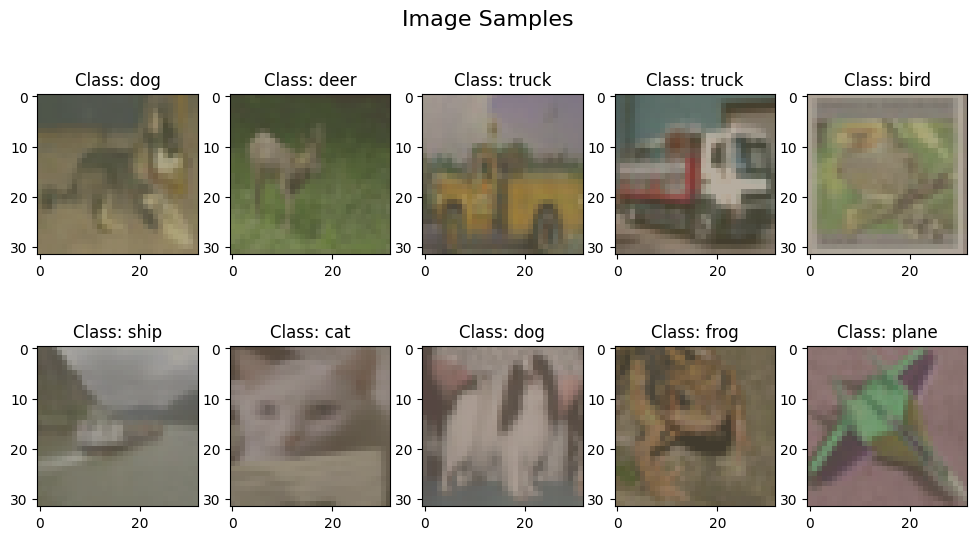

In [4]:
unnormalize = v2.Compose([
    v2.Normalize((0.0, 0.0, 0.0), (1/0.229, 1/0.224, 1/0.225)),
    v2.Normalize((-0.485, -0.456, -0.406), (1.0, 1.0, 1.0)),
])

fig, ax = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Image Samples', fontsize=16)

dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(10):
    img = np.transpose(unnormalize(images[i]).numpy(), (1, 2, 0))
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].set_title(f'Class: {CLASSES[labels[i]]}')
    ax[i//5, i%5].axis('on')


In [5]:
class ConvolutionModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5), # 5x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 5x14x14
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3), # 16x12x12
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), # 32x10x10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1), # 32x9x9
        )

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 9 * 9, 128),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(), nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(self.convs(x))

In [6]:
model = ConvolutionModel().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [8]:
epochs = 25

train_loss_list = []
val_loss_list = []
for epoch in range(epochs):
    train_loss = 0.0
    for batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        y_pred = model(images)
        loss = loss_fn(y_pred, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Looked at {batch * len(images)}/{len(train_loader.dataset)} samples")

    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            y_val_pred = model(images)
            val_loss += loss_fn(y_val_pred, labels).item()
            val_acc += accuracy_fn(labels, y_val_pred.argmax(1))
        val_loss /= len(test_loader)
        val_loss_list.append(val_loss)
        val_acc /= len(test_loader)

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)
    print(f"{epoch:02d}: Train loss: {train_loss:.5f} | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")

Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
00: Train loss: 1.91126 | Validation loss: 1.57954, Validation acc: 40.34%
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
01: Train loss: 1.47973 | Validation loss: 1.35161, Validation acc: 50.70%
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
02: Train loss: 1.31453 | Validation loss: 1.26966, Validation acc: 54.55%
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
03: Train loss: 1.21063 | Validation loss: 1.14577, Validation acc: 58.75%
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
04: Train loss: 1.12411 | Validation loss: 1.09315, Validation acc: 60.95%
Looked at 0/50000 samples
Looked at 12800/500

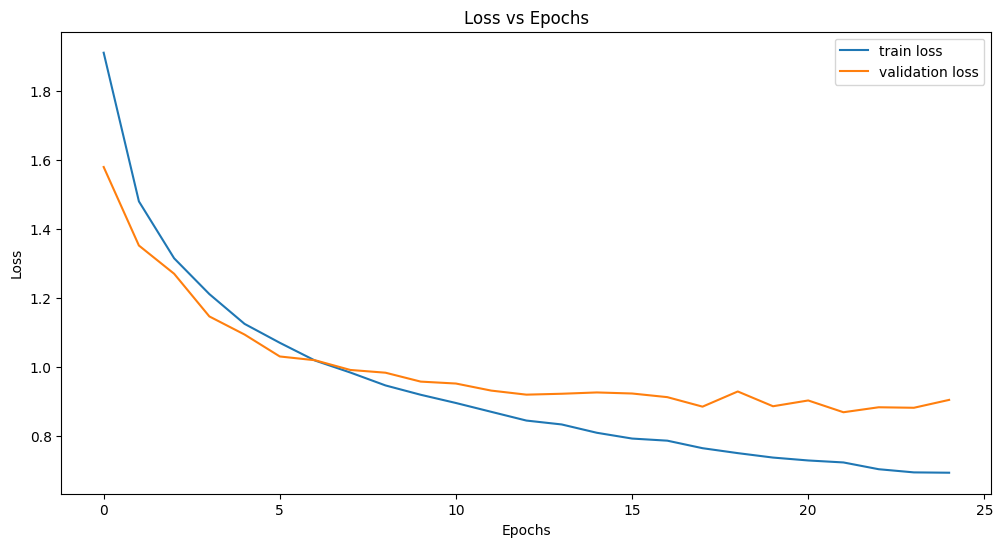

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_loss_list, label='train loss')
ax.plot(val_loss_list, label='validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Epochs')
ax.legend()

plt.show()

In [10]:
val_acc = 0.0
preds_all = []
labels_all = []
model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        y_val_pred = model(images)
        val_acc += accuracy_fn(labels, y_val_pred.argmax(dim=1))

        labels_all.extend(labels.cpu())
        preds_all.extend(y_val_pred.argmax(dim=1).cpu())
    val_acc /= len(test_loader)

preds_all = np.array(preds_all)
labels_all = np.array(labels_all)

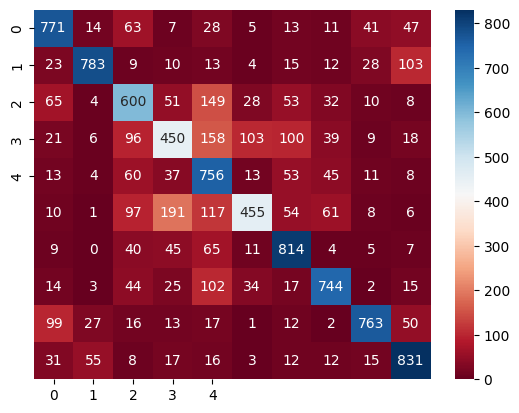

In [11]:
cmatrix = confusion_matrix(labels_all, preds_all)
classes = [0, 1, 2, 3, 4]
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=classes, yticklabels=classes)
plt.show()

In [12]:
print(classification_report(labels_all, preds_all))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1000
           1       0.87      0.78      0.83      1000
           2       0.58      0.60      0.59      1000
           3       0.53      0.45      0.49      1000
           4       0.53      0.76      0.62      1000
           5       0.69      0.46      0.55      1000
           6       0.71      0.81      0.76      1000
           7       0.77      0.74      0.76      1000
           8       0.86      0.76      0.81      1000
           9       0.76      0.83      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.69     10000
weighted avg       0.70      0.70      0.69     10000

